In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Input, TimeDistributed, Conv1D, Flatten, LSTM, Dropout, Dense,
                                     Layer, ConvLSTM2D, Conv3D, BatchNormalization, concatenate)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

In [2]:
# ==================== Load & Preprocess ====================
df = pd.read_csv('smart_traffic_management_dataset.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp')

# Time features
df['hour'] = df['timestamp'].dt.hour
df['dayofweek'] = df['timestamp'].dt.dayofweek
df['month'] = df['timestamp'].dt.month

# Encode categorical
for col in ['weather_condition', 'signal_status']:
    df[col] = LabelEncoder().fit_transform(df[col])

# Lag/rolling
df['traffic_volume_lag_1'] = df['traffic_volume'].shift(1)
df['traffic_volume_lag_3'] = df['traffic_volume'].shift(3)
df['traffic_volume_lag_6'] = df['traffic_volume'].shift(6)
df['traffic_volume_rollmean_6'] = df['traffic_volume'].rolling(window=6).mean()
df.dropna(inplace=True)

# Features & targets
features = ['location_id', 'avg_vehicle_speed', 'vehicle_count_cars', 'vehicle_count_trucks',
            'vehicle_count_bikes', 'weather_condition', 'temperature', 'humidity',
            'accident_reported', 'signal_status', 'hour', 'dayofweek', 'month',
            'traffic_volume_lag_1', 'traffic_volume_lag_3', 'traffic_volume_lag_6',
            'traffic_volume_rollmean_6']
target = 'traffic_volume'

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(df[features])
y_scaled = scaler_y.fit_transform(df[[target]])

In [3]:
# Create sequences
SEQ_LEN = 30
FORECAST_HORIZON = 30

def create_sequences(X, y, seq_len=30, forecast_horizon=30):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len - forecast_horizon):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len + forecast_horizon - 1])
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X_scaled, y_scaled, SEQ_LEN, FORECAST_HORIZON)

In [4]:
# ==================== Shared Train/Test ====================
split = int(len(X_seq) * 0.8)
X_train_raw, X_test_raw = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]



In [5]:
# ========== ConvLSTM ==========
X_train_conv = X_train_raw.reshape((X_train_raw.shape[0], SEQ_LEN, X_seq.shape[2], 1, 1))
X_test_conv = X_test_raw.reshape((X_test_raw.shape[0], SEQ_LEN, X_seq.shape[2], 1, 1))

model_conv = Sequential([
    ConvLSTM2D(64, (3, 1), activation='relu', return_sequences=True, input_shape=(SEQ_LEN, X_seq.shape[2], 1, 1)),
    BatchNormalization(),
    ConvLSTM2D(32, (2, 1), activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='linear')
])

model_conv.compile(optimizer=Adam(0.0005), loss='mse', metrics=['mae'])
model_conv.fit(X_train_conv, y_train, epochs=50, batch_size=32, validation_data=(X_test_conv, y_test),
               callbacks=[EarlyStopping(patience=5, restore_best_weights=True)], verbose=0)

y_pred_conv = model_conv.predict(X_test_conv)
y_pred_conv_inv = scaler_y.inverse_transform(y_pred_conv)

C:\Users\aidilfadzni\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


In [6]:
# ========== CNN-LSTM ==========
subsequences = 10
steps_per_subseq = SEQ_LEN // subsequences
X_train_cnn = X_train_raw.reshape((X_train_raw.shape[0], subsequences, steps_per_subseq, X_seq.shape[2]))
X_test_cnn = X_test_raw.reshape((X_test_raw.shape[0], subsequences, steps_per_subseq, X_seq.shape[2]))

class Attention(Layer):
    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1), initializer="normal", trainable=True)
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1), initializer="zeros", trainable=True)
        super().build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a
        return K.sum(output, axis=1)

input_layer = Input(shape=(subsequences, steps_per_subseq, X_seq.shape[2]))
x = TimeDistributed(Conv1D(64, kernel_size=2, activation='relu'))(input_layer)
x = TimeDistributed(Flatten())(x)
x = LSTM(100, return_sequences=True)(x)
x = Dropout(0.3)(x)
x = Attention()(x)
x = Dense(64, activation='relu')(x)
output = Dense(1)(x)

model_cnn = Model(inputs=input_layer, outputs=output)
model_cnn.compile(optimizer='adam', loss='mse', metrics=['mae'])
model_cnn.fit(X_train_cnn, y_train, validation_split=0.2, epochs=100, batch_size=32,
              callbacks=[EarlyStopping(patience=8, restore_best_weights=True)], verbose=0)

y_pred_cnn = model_cnn.predict(X_test_cnn)
y_pred_cnn_inv = scaler_y.inverse_transform(y_pred_cnn)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


In [7]:
# ========== UNet-ConvLSTM ==========
X_full = X_seq.reshape((X_seq.shape[0], SEQ_LEN, X_seq.shape[2], 1, 1))
X_train_u, X_test_u, y_train_u, y_test_u = train_test_split(X_full, y_seq, test_size=0.2, random_state=42)

inputs = Input(shape=(SEQ_LEN, X_seq.shape[2], 1, 1))
e1 = ConvLSTM2D(32, (3, 1), padding='same', return_sequences=True, activation='relu')(inputs)
e1 = BatchNormalization()(e1)
e2 = ConvLSTM2D(64, (3, 1), padding='same', return_sequences=True, activation='relu')(e1)
e2 = BatchNormalization()(e2)
bottleneck = ConvLSTM2D(128, (3, 1), padding='same', return_sequences=True, activation='relu')(e2)
bottleneck = BatchNormalization()(bottleneck)
bottleneck = Dropout(0.3)(bottleneck)
d1 = ConvLSTM2D(64, (3, 1), padding='same', return_sequences=True, activation='relu')(bottleneck)
d1 = BatchNormalization()(d1)
d1 = concatenate([d1, e2])
d2 = ConvLSTM2D(32, (3, 1), padding='same', return_sequences=True, activation='relu')(d1)
d2 = BatchNormalization()(d2)
d2 = concatenate([d2, e1])
output_3d = Conv3D(1, (1, 1, 1), activation='linear')(d2)
x_flat = Flatten()(output_3d)
x_dense = Dense(64, activation='relu')(x_flat)
x_dense = Dropout(0.2)(x_dense)
final_output = Dense(1, activation='linear')(x_dense)

model_unet = Model(inputs, final_output)
model_unet.compile(optimizer='adam', loss='mse', metrics=['mae'])
model_unet.fit(X_train_u, y_train_u, validation_data=(X_test_u, y_test_u), epochs=100, batch_size=32,
               callbacks=[EarlyStopping(patience=10, restore_best_weights=True), ReduceLROnPlateau(factor=0.5, patience=5)], verbose=1)

y_pred_unet = model_unet.predict(X_test_u)
y_pred_unet_inv = scaler_y.inverse_transform(y_pred_unet)
y_test_unet_inv = scaler_y.inverse_transform(y_test_u.reshape(-1, 1))

Epoch 1/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 25s 403ms/step - loss: 0.6322 - mae: 0.5887 - val_loss: 0.2636 - val_mae: 0.4312 - learning_rate: 0.0010
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 20s 406ms/step - loss: 0.1371 - mae: 0.2973 - val_loss: 0.2651 - val_mae: 0.4325 - learning_rate: 0.0010
Epoch 3/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 389ms/step - loss: 0.1041 - mae: 0.2688 - val_loss: 0.2869 - val_mae: 0.4543 - learning_rate: 0.0010
Epoch 4/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 394ms/step - loss: 0.1016 - mae: 0.2668 - val_loss: 0.2490 - val_mae: 0.4168 - learning_rate: 0.0010
Epoch 5/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 387ms/step - loss: 0.0921 - mae: 0.2548 - val_loss: 0.2080 - val_mae: 0.3766 - learning_rate: 0.0010
Epoch 6/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 388ms/step - loss: 0.0942 - mae: 0.2594 - val_loss: 0.1506 - val_mae: 0.3208 - learning_rate: 0.0010
Epoch 7/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 384ms/step - loss: 0.0934 - mae: 0.2594 - val_loss: 0.1319 - val_mae: 0.3027 - learning_rate:

In [16]:
# ========== Evaluation ==========
y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1, 1))

print(f"\n\U0001F4C9 ConvLSTM    MAE: {mean_absolute_error(y_test_inv, y_pred_conv_inv):.2f}, MSE: {mean_squared_error(y_test_inv, y_pred_conv_inv):.2f}, R²: {r2_score(y_test_inv, y_pred_conv_inv):.4f}")
print(f"\U0001F4CA CNN-LSTM    MAE: {mean_absolute_error(y_test_inv, y_pred_cnn_inv):.2f}, MSE: {mean_squared_error(y_test_inv, y_pred_cnn_inv):.2f}, R²: {r2_score(y_test_inv, y_pred_cnn_inv):.4f}")
print(f"\U0001F4C8 UNet-ConvLSTM MAE: {mean_absolute_error(y_test_unet_inv, y_pred_unet_inv):.2f}, MSE: {mean_squared_error(y_test_unet_inv, y_pred_unet_inv):.2f}, R²: {r2_score(y_test_unet_inv, y_pred_unet_inv):.5f}")



📉 ConvLSTM    MAE: 240.12, MSE: 77509.96, R²: 0.0089
📊 CNN-LSTM    MAE: 243.35, MSE: 78252.84, R²: -0.0006
📈 UNet-ConvLSTM MAE: 238.15, MSE: 76906.83, R²: -0.00004


In [9]:
print("\n📋 ConvLSTM - Last 20 Actual vs Predicted Traffic Volume:")
df_conv = pd.DataFrame({
    "Index": np.arange(len(y_test_inv) - 19, len(y_test_inv) + 1),
    "Actual": y_test_inv[-20:].flatten(),
    "Predicted": y_pred_conv_inv[-20:].flatten()
})
print(df_conv.to_string(index=False, float_format='{:,.2f}'.format))

print("\n📋 CNN-LSTM - Last 20 Actual vs Predicted Traffic Volume:")
df_cnn = pd.DataFrame({
    "Index": np.arange(len(y_test_inv) - 19, len(y_test_inv) + 1),
    "Actual": y_test_inv[-20:].flatten(),
    "Predicted": y_pred_cnn_inv[-20:].flatten()
})
print(df_cnn.to_string(index=False, float_format='{:,.2f}'.format))

print("\n📋 UNet-ConvLSTM - Last 20 Actual vs Predicted Traffic Volume:")
df_unet = pd.DataFrame({
    "Index": np.arange(len(y_test_unet_inv) - 19, len(y_test_unet_inv) + 1),
    "Actual": y_test_unet_inv[-20:].flatten(),
    "Predicted": y_pred_unet_inv[-20:].flatten()
})
print(df_unet.to_string(index=False, float_format='{:,.2f}'.format))


📋 ConvLSTM - Last 20 Actual vs Predicted Traffic Volume:
 Index  Actual  Predicted
   368  342.00     556.39
   369  859.00     552.15
   370  962.00     551.78
   371  150.00     556.62
   372  551.00     564.11
   373  353.00     573.63
   374  920.00     576.64
   375  589.00     580.95
   376  602.00     588.85
   377  404.00     598.01
   378  352.00     602.45
   379  545.00     598.05
   380  707.00     592.30
   381  817.00     583.20
   382  276.00     574.35
   383  285.00     567.90
   384  922.00     557.63
   385  941.00     550.50
   386  504.00     543.29
   387   62.00     544.70

📋 CNN-LSTM - Last 20 Actual vs Predicted Traffic Volume:
 Index  Actual  Predicted
   368  342.00     559.49
   369  859.00     547.13
   370  962.00     566.59
   371  150.00     550.95
   372  551.00     542.57
   373  353.00     546.37
   374  920.00     554.05
   375  589.00     531.49
   376  602.00     538.31
   377  404.00     547.23
   378  352.00     541.96
   379  545.00     536.18


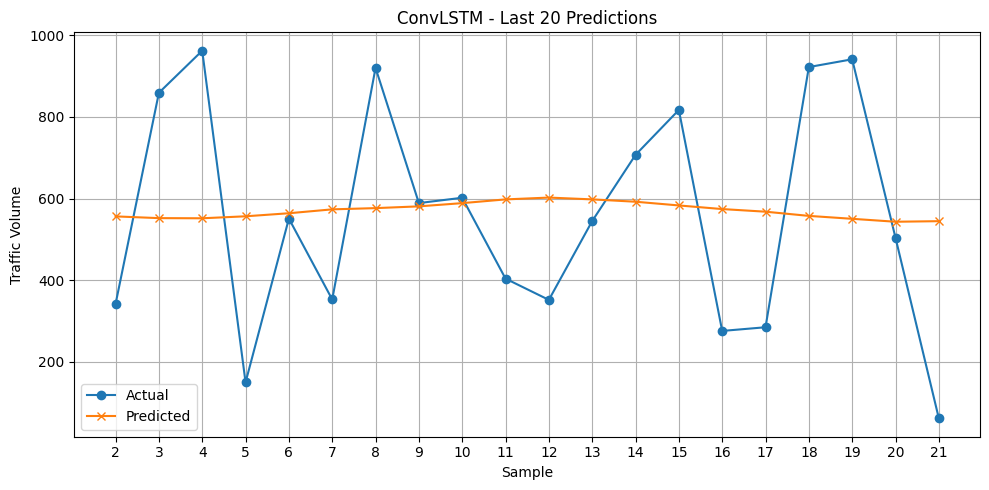

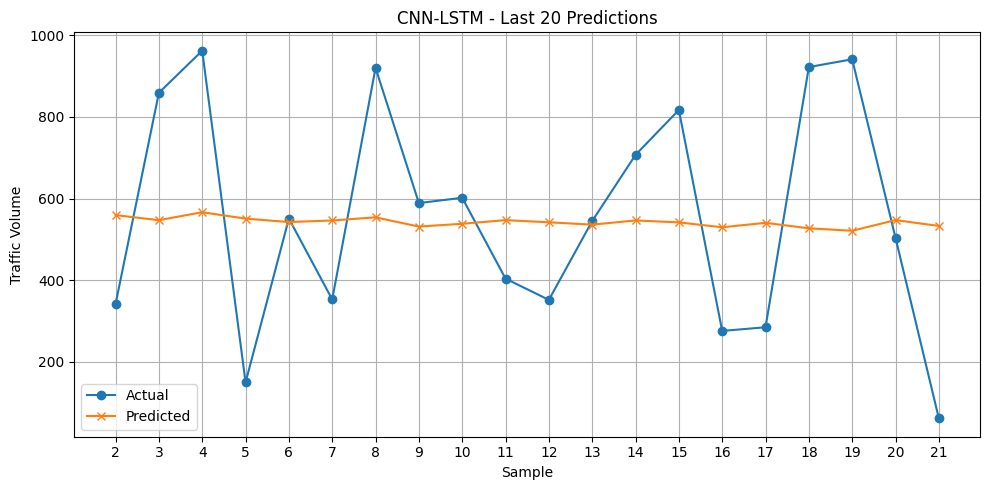

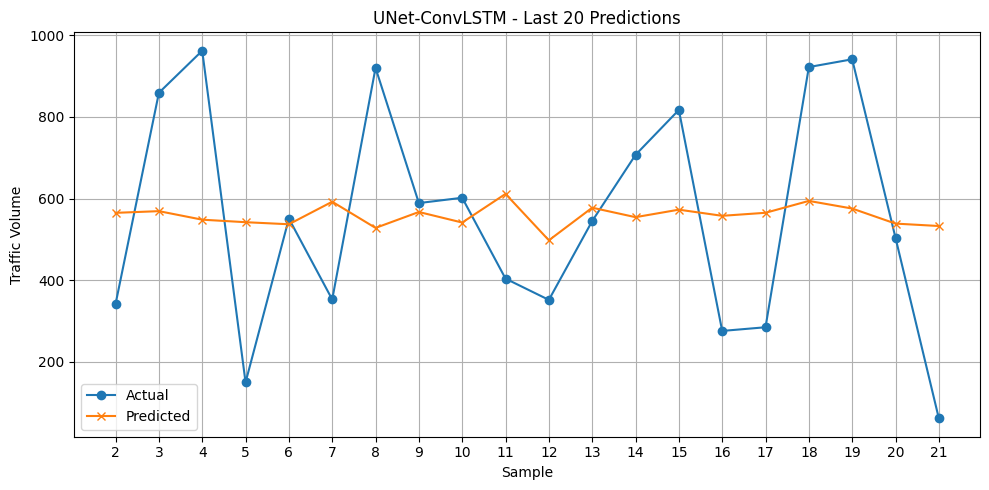

In [10]:
# ========== Plotting ==========
def plot_last_20(title, actual, predicted):
    actual_last20 = actual[-20:].flatten()
    predicted_last20 = predicted[-20:].flatten()
    plt.figure(figsize=(10, 5))
    plt.plot(actual_last20, label='Actual', marker='o')
    plt.plot(predicted_last20, label='Predicted', marker='x')
    plt.title(title)
    plt.xlabel("Sample")
    plt.ylabel("Traffic Volume")
    plt.xticks(ticks=np.arange(20), labels=[str(i+1) for i in range(1, 21)])
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_last_20("ConvLSTM - Last 20 Predictions", y_test_inv, y_pred_conv_inv)
plot_last_20("CNN-LSTM - Last 20 Predictions", y_test_inv, y_pred_cnn_inv)
plot_last_20("UNet-ConvLSTM - Last 20 Predictions", y_test_inv, y_pred_unet_inv)

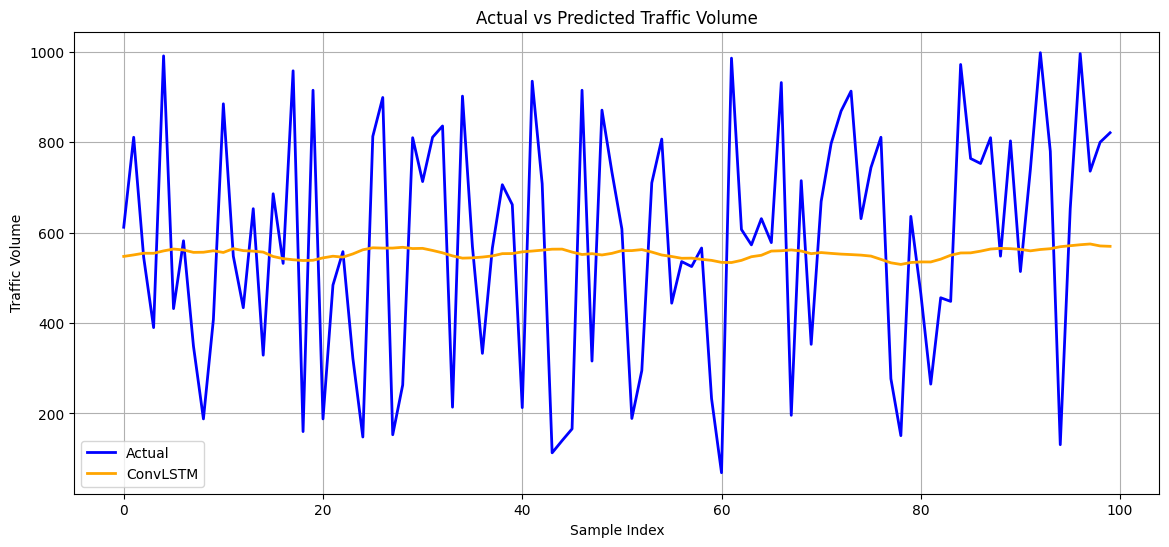

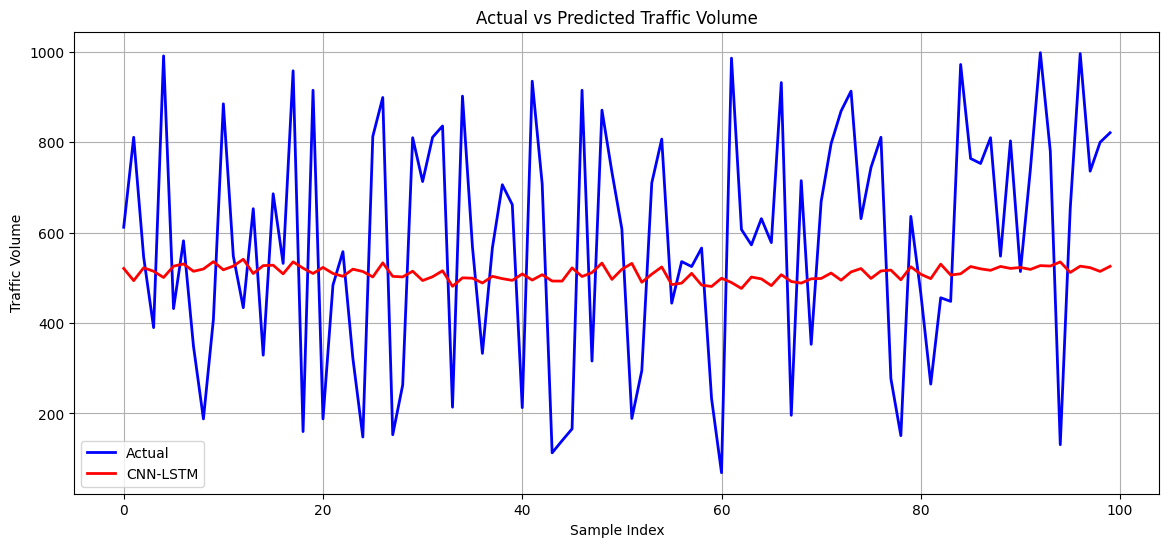

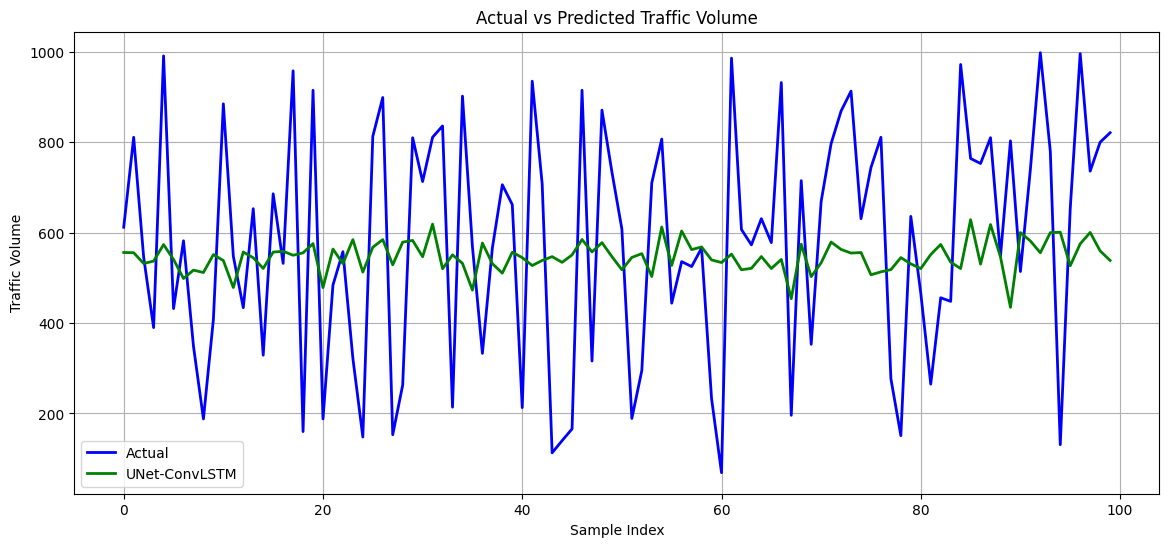

In [14]:
plt.figure(figsize=(14, 6))
plt.plot(y_test_inv[:100], label='Actual', color='blue', linewidth=2)
plt.plot(y_pred_conv_inv[:100], label='ConvLSTM', color='orange', linewidth=2)
plt.title("Actual vs Predicted Traffic Volume")
plt.xlabel("Sample Index")
plt.ylabel("Traffic Volume")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(14, 6))
plt.plot(y_test_inv[:100], label='Actual', color='blue', linewidth=2)
plt.plot(y_pred_cnn_inv[:100], label='CNN-LSTM', color='red', linewidth=2)
plt.title("Actual vs Predicted Traffic Volume")
plt.xlabel("Sample Index")
plt.ylabel("Traffic Volume")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(14, 6))
plt.plot(y_test_inv[:100], label='Actual', color='blue', linewidth=2)
plt.plot(y_pred_unet_inv[:100], label='UNet-ConvLSTM', color='green', linewidth=2)
plt.title("Actual vs Predicted Traffic Volume")
plt.xlabel("Sample Index")
plt.ylabel("Traffic Volume")
plt.legend()
plt.grid(True)
plt.show()

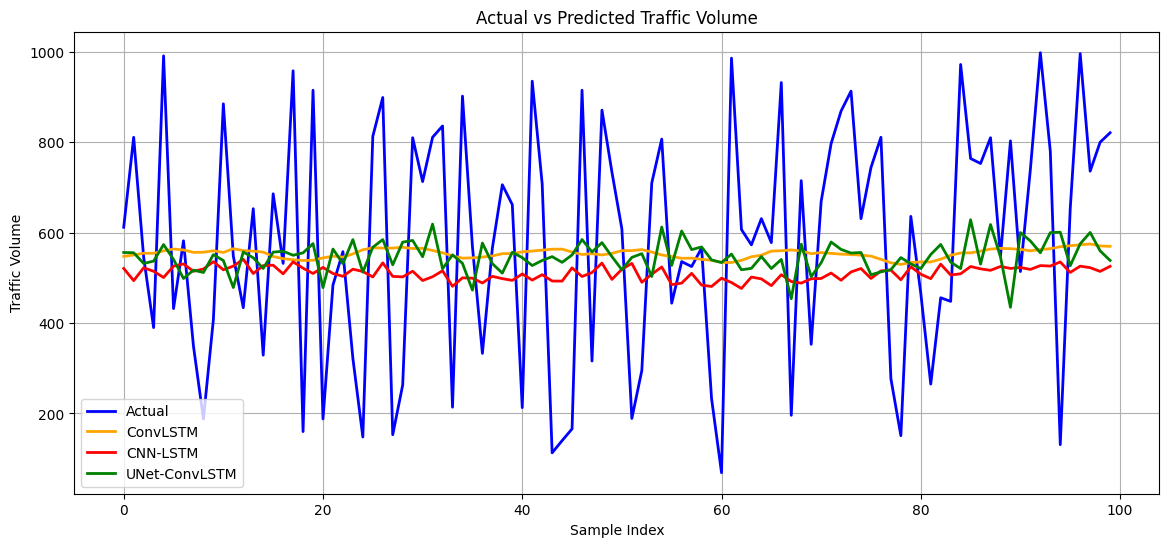

In [13]:
plt.figure(figsize=(14, 6))
plt.plot(y_test_inv[:100], label='Actual', color='blue', linewidth=2)
plt.plot(y_pred_conv_inv[:100], label='ConvLSTM', color='orange', linewidth=2)
plt.plot(y_pred_cnn_inv[:100], label='CNN-LSTM', color='red', linewidth=2)
plt.plot(y_pred_unet_inv[:100], label='UNet-ConvLSTM', color='green', linewidth=2)
plt.title("Actual vs Predicted Traffic Volume")
plt.xlabel("Sample Index")
plt.ylabel("Traffic Volume")
plt.legend()
plt.grid(True)
plt.show()